# **<center><font style="color:rgb(100,109,254)">Module 9: Full-Body Sign Language Recognition</font> </center>**

<center>
    <img src='https://drive.google.com/uc?export=download&id=1kqMdoDJrt-YxUDPB0YLHcp9f3XAVTRsi' width=800> 
    <br/>
    <a href='https://www.signall.us'>Image Credits</a>
</center>
    

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to Long Short-Term Memory (LSTM) Networks Theory.*

- *Lesson 2: Collect Sign Language Recognition Dataset.*

- ***Lesson 3:*  Train a Sign Language Recognition LSTM Network.** *(This Tutorial)*


**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from collections import deque
import matplotlib.pyplot as plt
from previous_lesson import extractPoseKeypoints
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import plot_model

Tensorflow version:  2.9.1


## **<font style="color:rgb(134,19,348)">Initialize the Pose Detection Model</font>**


After that, as we had done in the previous lesson, we will have to initialize the **`mp.solutions.pose`** class and then set up the **`mp.solutions.pose.Pose()`** function with the appropriate arguments.

In [2]:
# Initialize the mediapipe pose class.
mp_pose = mp.solutions.pose

# Set up the pose landmarks function for videos.
pose_videos = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, 
                           enable_segmentation=True, smooth_segmentation=True, 
                           min_detection_confidence=0.5, min_tracking_confidence=0.8)

Now we will initialize the parameters like the classes on which we want our model to train, and the length of each sequence in the dataset along with the path where the dataset is stored.

In [3]:
# Specify the path where the dataset is stored.
DATASET_DIR = 'dataset'

# Specify the number of frames of a video that will be fed to the model as one sequence.
sequence_length = 30 

# Initialize the list containing the classes on which we want to train our model.
classes_list = ["Hello", "bye", "Thankyou"]

## **<font style="color:rgb(134,19,348)">Load the Dataset</font>**

As we have the landmarks dataset stored in our disk that we have collected in the previous lesson, we can now load it utilizing the [**`numpy.load()`**](https://numpy.org/doc/stable/reference/generated/numpy.load.html#numpy-load) function.

In [4]:
# Initialize lists to store the landmarks and labels.
landmarks, labels = [], []

# Iterate over the classes.
for class_index, label in enumerate(classes_list):
    
    # Get the directory path of the class, we are iterating upon. 
    dir_path = os.path.join(DATASET_DIR, label)
    
    # Check if the directory exists.
    if os.path.exists(dir_path):
        
        # Get the files names in the directory.
        file_names = os.listdir(dir_path)
        
        # Iterate over the files names.
        for file_name in file_names:
            
            # Load the landmarks data from the file.
            video_landmarks = np.load(os.path.join(dir_path, file_name))
            
            # Append the landmarks into the list.
            landmarks.append(video_landmarks)
            
            # Append the label index into the list.
            labels.append(class_index)

# Convert the landmarks list into an array.           
landmarks = np.array(landmarks)

# Convert labels into one-hot-encoded vectors using Keras's to_categorical function.
labels = to_categorical(labels).astype(int)

# Display the success message. 
print(f"Data loaded successfully.")    

Data loaded successfully.


## **<font style="color:rgb(134,19,348)"> Split the dataset into Train and Test Set</font>**

Now, as we know from our previous module, we will need a test set to evaluate our model's performance after training. So now we will split our dataset into train and test subsets randomly using the function [**`sklearn.model_selection.train_test_split()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split).

In [5]:
# Split the dataset into random train and test subsets.
train_landmarks, test_landmarks, train_labels, test_labels = train_test_split(landmarks, labels, test_size=0.05)

In [6]:
# Check the input Shape
print(train_landmarks[0].shape)

(30, 66)


## **<font style="color:rgb(134,19,348)">Construct the Model</font>**

To construct the model, we will use the [**`tf.keras.Sequential()`**](https://keras.io/api/models/sequential/) class to linearly stack the layers of the model. We will use a bunch of [**`tf.keras.layers.LSTM()`**](https://keras.io/api/layers/recurrent_layers/lstm/) layers along with a few [**`tf.keras.layers.Dense()`**](https://keras.io/api/layers/core_layers/dense/) layers in the end.

In [7]:
# We will use a Sequential model.
model = Sequential()

# Define the Model Architecture.
####################################################################################################    
model.add(LSTM(64, return_sequences=True, activation='relu',
               input_shape=train_landmarks[0].shape))

model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(len(classes_list), activation='softmax'))
####################################################################################################

# Display the model's summary.
model.summary()
    
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            33536     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 30, 256)           394240    
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           197120    
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2

## **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**


And now, finally, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training of the model.

In [8]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_training_history = model.fit(x = train_landmarks, y = train_labels, epochs = 200, batch_size = 16,
                                   callbacks = [early_stopping_callback],
                                   validation_split = 0.2, shuffle = True)

Epoch 1/200
5/5 [==============================] - 26s 1000ms/step - loss: 1.0916 - accuracy: 0.4853 - val_loss: 1.0580 - val_accuracy: 1.0000
Epoch 2/200
5/5 [==============================] - 2s 485ms/step - loss: 1.0942 - accuracy: 0.8971 - val_loss: 0.6797 - val_accuracy: 1.0000
Epoch 3/200
5/5 [==============================] - 5s 1s/step - loss: 0.9026 - accuracy: 0.7941 - val_loss: 0.8880 - val_accuracy: 0.4706
Epoch 4/200
5/5 [==============================] - 3s 689ms/step - loss: 0.9494 - accuracy: 0.4118 - val_loss: 0.9274 - val_accuracy: 0.2353
Epoch 5/200
5/5 [==============================] - 3s 571ms/step - loss: 0.8932 - accuracy: 0.5441 - val_loss: 0.5146 - val_accuracy: 0.5882
Epoch 6/200
5/5 [==============================] - 3s 532ms/step - loss: 1.0353 - accuracy: 0.6765 - val_loss: 0.4859 - val_accuracy: 1.0000
Epoch 7/200
5/5 [==============================] - 3s 545ms/step - loss: 0.7367 - accuracy: 0.7059 - val_loss: 0.5450 - val_accuracy: 0.7647
Epoch 8/200
5/

## **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will check the model's performance on the test set.

In [9]:
# Evaluate the trained model.
model_evaluation = model.evaluate(test_landmarks, test_labels)

1/1 [==============================] - 0s 360ms/step - loss: 0.0629 - accuracy: 1.0000


## **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**

Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have metrics stored in the variable **`model_training_history`** that is returned by the **`model.fit()`** function, representing how our model performed on the training and validation set during each training epoch, so now we just have to visualize them.

In [10]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize the loss and accuracy metrics.

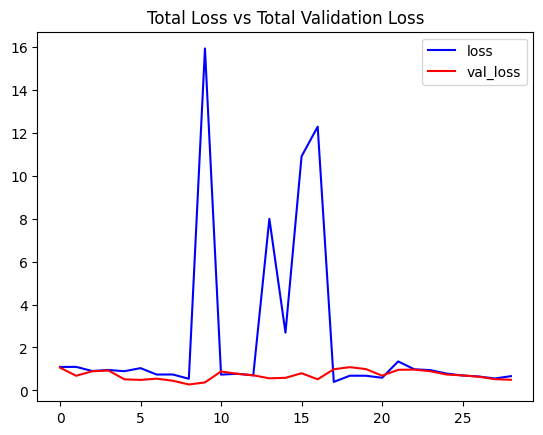

In [11]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

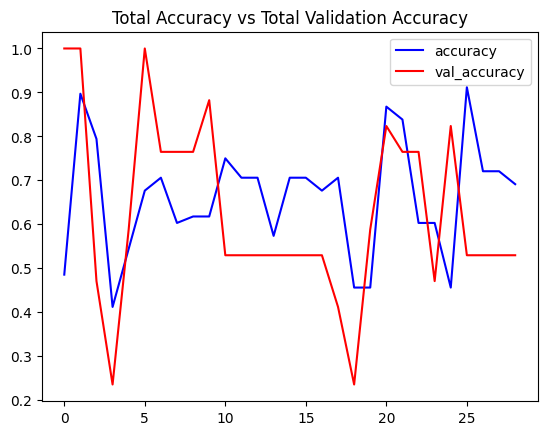

In [12]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model on our disk to avoid training it from scratch every time we need the model.

In [13]:
# Specify the path of the directory in which you want to store the model.
model_dir = 'Model'

# Check if the directory does not already exist.
if not os.path.exists(model_dir):
    
    # Create the directory.
    os.mkdir(model_dir)

# Save the Model.
model.save(f'{model_dir}/sign_language_recognizer.h5')

## **<font style="color:rgb(134,19,348)">Predict Signs On a Real-Time Web-cam Feed</font>**

Now let's use our trained model to perform Sign Language Recognition on a real-time webcam feed.

In [17]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Sign Language Recognition', cv2.WINDOW_NORMAL)

# Load the model from disk.
loaded_model = load_model('Model/sign_language_recognizer.h5')

# Initialize a deque to store the frames.
sequence = deque([], maxlen=sequence_length)

# Initialize a variable to store the buffer length.
BUFFER_MAX_LENGTH = 2

# Initialize a buffer to store the prediction results.
buffer = deque([], maxlen=BUFFER_MAX_LENGTH)

# Initialize a variable to store the minimum prediction confidence.
threshold = 0.55

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
   
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then
    # continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Extract the required pose keypoints of the person in the frame.
    frame, extracted_keypoints = extractPoseKeypoints(frame, pose_videos)
    
    # Append the extracted keypoints into the deque.
    sequence.append(extracted_keypoints)
    
    # Check if the length of the deque is equal to the required sequence length.
    if len(sequence) == sequence_length:
        
        # Predict the Sign, the person is making in the sequence.
        prediction_probs = loaded_model.predict(np.expand_dims(sequence, axis=0))[0]
        
        # Check if the highest predicted probability of a class is > the threshold value.
        if prediction_probs[np.argmax(prediction_probs)] > threshold:
            
            # Get the class (Sign) name which has the highest predicted probability.
            current_sign = classes_list[np.argmax(prediction_probs)]
            
            # Append the predicted class into the buffer.
            buffer.append(current_sign)
            
        # Otherwise.
        else:
            
            # Check if the length of the buffer is > zero.
            if len(buffer) > 0:
                
                # Remove an element from the left side of the deque. 
                buffer.popleft()
    
    # Check if the length of the buffer is equal to the maxlength.
    if len(buffer) == BUFFER_MAX_LENGTH:
        
        # Write the predicted class on the frame.
        cv2.putText(frame, f'{max(buffer).upper()}!', (int(frame_width/2)-(len(max(buffer))*50),
                                                       int(frame_height/2)+100),
                    cv2.FONT_HERSHEY_PLAIN, 10, (0,255,0), 7)
        
    # Display the frame.
    cv2.imshow("Sign Language Recognition", frame)
    
    # Wait for 1ms.
    # If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break
        
# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 85ms/step


Fascinating right? predicting all three signs accurately!

In [15]:
# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

### **<font style="color:rgb(134,19,348)">Troubleshooting Issues:</font>**

**If you're not getting good results, here are some of the things you can do:**

- Increase the dataset size from 90 to a higher number.
- Make sure the classes you're recognizing are reasonablly different from each other.
- Record videos properly, the higher the quality of the dataset, the better the results.
- You can also experiment with changing hyperparameters to the network, adding regularization and so on, this should only be done by those with prior Deep learning experience.
- Instead of capturing landmarks and training an LSTM on that, you can also go for a CNN-LSTM approach, like i've done [here](https://bleedai.com/human-activity-recognition-using-tensorflow-cnn-lstm/) I've used this for video classification but you can also do sign language recognition, which falls under the same category.
- If you want to know to see a Sate of the Art Opensource repo for video based sign language recognition, then [project Shuwa is execellent, just check it out](https://github.com/google/shuwa). You can use this. It uses a very simiilar approach that we have used, but it leverages multiple pose detection models.


### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```


